# Abstract - Summary

In this project I will fetch data about businesses from the yelp API within 15 miles of UMBC.  In section one, "Getting Data" I will show the process of using the yelp API in order to retreive the data back as json and parsing it into a csv which is then loaded as a pandas dataframe.  This leads to the next section, "Data Analysis" where I perform some analysis on the pandas dataframe to find stats and information in the data for problems such as good cheap restaraunts and how close they are to UMBC.  For example, if UMBC is recruiting new students, it may be helpful for new recurits to be able to see how close restaurants are to campus and the availability of them.  Finally in the conclusions section I will summarize the findings.


# Getting Data

In this section we have the code for receiving the data, cleaning it, and putting it into a csv file.

In [47]:
#imports
import requests #for making the we requests
import json  #for loading the text to json
from configparser import ConfigParser  #for loading the API key from a config file
import csv #for writing to a csv
import pandas as pd #for data analysis
from tabulate import tabulate #for creating tables

For the next code block below, it will not necessarily need to be changed in order to run properly, but the runner of this notebook will need to place a secret.cfg file two directories up with an auth and token section - these are from yelp - to be authenticated upon each call.  You may create a yelp account here: https://www.yelp.com/developers.  And once an account is created, create an app.  Once the app is created, from the manage app page there will be a Client ID and API key.  Put the Client Id in a 'auth' section of the secret.cfg file, and the API key in the 'token' section of the same file.

In [51]:
#load the API key from a file a few directories up so that it is not stored in the git repo.
#this code will not need to be changed in order to run properly, but the runner of this notebook will need to
#place a secret.cfg file two directories up with an auth and token section - these are from yelp - to be authenticated
#upon each call
config = ConfigParser()
config.read('../../secret.cfg')
token = config.get('auth', 'token')

#set it as the header
headers = {'Authorization': 'Bearer %s' % token}

In [52]:
#set the url to the yelp API
url='https://api.yelp.com/v3/businesses/search'
 
#From the yelp API docs, there are a bunch of categories.  I went through and found ones that I believed would
#be of interest to college students.
interestingCategories = ["atvrentals", "airsoft", "amateursportsteams","amusementparks","aquariums","archery","axethrowing","badminton","baseballfields","beaches","bicyclepaths", "bikerentals", "bikeparking", "boating", "bobsledding", "bocceball", "bowling", "bungeejumping", "climbing", "daycamps", "discgolf", "diving", "escapegames", "fencing", "fishing", "fitness", "flyboarding","gokarts","golf","gun_ranges","hiking","horsebackriding","jetskis","lasertag","mini_golf","mountainbiking","paddleboarding","paintball","parks","playgrounds","races","rafting","recreation","sailing","football","swimmingpools","tennis","skatingrinks","arcades","galleries","bingo","movietheaters","eatertainment","festivals","musicvenues","theater","social_clubs","stadiumsarenas","ticketsales","wineries","acnetreatment","barbers","spas","massage","bicycles","acaibowls", "backshop", "bagels", "bakeries", "beer_and_wine", "bento", "beverage_stores", "breweries", "bubbletea", "butcher", "csa", "chimneycakes", "churros", "cideries", "coffee", "coffeeteasupplies", "coffeeroasteries", "convenience", "cupcakes", "customcakes", "delicatessen", "desserts", "distilleries", "diyfood", "donairs", "donuts", "empanadas", "farmersmarket", "fishmonger", "fooddeliveryservices", "foodtrucks",  "friterie", "gelato","grocery","hawkercentre", "honey","icecream","importedfood","intlgrocery","internetcafe","jpsweets","juicebars","kiosk", "kombucha","meaderies", "milkshakebars","gluhwein", "nasilemak","organic_stores", "panzerotti", "eltern_cafes", "cakeshop","piadinapoke", "pretzels", "shavedice", "shavedsnow", "smokehouse", "gourmet", "streetvendors", "sugarshacks", "tea", "tortillas", "wineries","adultentertainment","barcrawl","bars","beergardens","clubcrawl","coffeeshops","comedyclubs","danceclubs","dancerestaurants","karaoke","musicvenues","pianobars","poolhalls","petstore","restaurants","shopping"]

In the below block of code is nested loops.  The outer goes through each category in the list of categories that I believed would be interesting to college students.  The reason I spent the time going through all these groups rather than just simply seraching for terms like 'food' or 'fun' is because of a limitation with the yelp API.  For any one particular query, a maximum of 1,000 businesses may be obtained with it (offset cannot be used above 1,000) and so with breaking the calls down to more specific categories, that minimizes the number of calls that return a number of businesses greater than 1,000 which results in more data for us both in numbers and of higher quality as less is missing.

In [4]:
businesses = []  #start with empty array of businesses to build on
FIFTEEN_MILES = 24140 #this is 15 miles, measured in meters
MAX_RETURN_SIZE = 50 #the max yelp will return is 50 businesses at a time

for category in interestingCategories:  #for each category of interest...
    #set the params and make the initial request
    params = {'categories':category, 'location':'1000 Hilltop Circle Baltimore, MD 21250', 'radius': FIFTEEN_MILES, 'limit':MAX_RETURN_SIZE, 'sort_by':'rating'}
    req=requests.get(url, params=params, headers=headers)
    
    #check the status code of the response
    print('The status code is {}'.format(req.status_code))
    if req.status_code != 200:
        continue  #if it failed... just continue without breaking the process
    resp = json.loads(req.text) #load the text of the response to json
    offset = 0  #use the offset to page through the results
    numToGet = resp["total"]
    numReceived = len(resp["businesses"])
    for business in resp["businesses"]:  #create column of category for each business to save what it was found on
        business["category"] = category
    businesses.extend(resp['businesses']) #extend the business array with the businesses
    while numToGet > numReceived: #while there are still more to get...
        offset += len(resp["businesses"])
        if offset == 1000: #stop at 1000 - this is the limit set by yelp
            break
        #set the params again this time with the updated offset
        params = {'category':category, 'location':'1000 Hilltop Circle Baltimore, MD 21250', 'radius': 24140, 'limit':50, 'offset':offset, 'sort_by':'rating'}
        req=requests.get(url, params=params, headers=headers) #make the request again
        # proceed only if the status code is 200
        print('The status code is {}'.format(req.status_code))
        resp = json.loads(req.text) #load the text to json
        if 'businesses' in resp: #check for the businesses in the output
            numReceived += len(resp["businesses"]) #increase the num received by what we got
            for business in resp["businesses"]:
                business["category"] = category #add the category for these as well
        else:
            break
        businesses.extend(resp['businesses']) #extend the businesses array with the found businesses

The status code is 200
The status code is 200
The status code is 200
The status code is 200
The status code is 200
The status code is 200
The status code is 200
The status code is 200
The status code is 200
The status code is 200
The status code is 200
The status code is 200
The status code is 200
The status code is 200
The status code is 200
The status code is 200
The status code is 200
The status code is 200
The status code is 200
The status code is 200
The status code is 200
The status code is 200
The status code is 200
The status code is 200
The status code is 200
The status code is 200
The status code is 200
The status code is 200
The status code is 200
The status code is 200
The status code is 200
The status code is 200
The status code is 200
The status code is 200
The status code is 200
The status code is 200
The status code is 200
The status code is 200
The status code is 200
The status code is 200
The status code is 200
The status code is 200
The status code is 200
The status 

In [ ]:
#parse the results and write to a csv file
with open('../data/scrapedData.csv', mode='w') as employee_file: #open the csv file...
    writer = csv.writer(employee_file, delimiter=',', quotechar='"', quoting=csv.QUOTE_MINIMAL) #create the writer...
    #write the first row with to be the headers
    writer.writerow(['id', 'alias', 'name', 'image_url', 'is_closed', 'url', 'review_count', 'categories', 'rating', 'latitude', 'longitude', 'distance', 'address', 'price', 'is_delivery', 'is_pickup', 'category'])
    for business in businesses: #loop through and write a row per business
        price = None #find the info for each business
        categoriesList = []
        categories = None
        isPickup = False
        isDelivery = False
        if 'price' in business:
            price = len(business['price']) #price represented as $, $$, $$$, $$$$ - convert to numeric to be used with sorting
        if 'categories' in business:
            for category in business['categories']:  #save the category titles in one string
                categoriesList.append(category['title'])
            categories = ", ".join(categoriesList)
        if 'delivery' in business['transactions']:
            isDelivery = True
        if 'pickup' in business['transactions']:
            isPickup = True
        writer.writerow([business["id"], business["alias"], business["name"], business["image_url"], business["is_closed"], business["url"], business["review_count"], categories, business["rating"], business["coordinates"]["latitude"], business["coordinates"]["longitude"], business["distance"], " ".join(business["location"]["display_address"]), price, isDelivery, isPickup, business["category"]])

Now we have the scraped data saved in the ../data directory as a csv file.  It can be loaded from any notebook and we will load it in the next section to perform the analysis on it using a pandas dataframe.

# Data Analysis

The question/ problem at hand here is finding stats and information that will help UMBC in recruiting more students to apply and attend the school.  UMBC is our customer, and the more quality students they can get, the more they can grow as a school and therefore it is of the utmost importance for the school to be able to attract the most talented students.

In this section I will do some analysis on the pandas dataframe to look for answers to questions that may help recruit some college students based on the businesses around UMBC.  Our target audience is students that would be coming to live on campus as any applicant close to UMBC with the option of commuting already knows what is around and what they enjoy around the Baltimore area.  So, the main essentials of what a student may look for in a school when leaving home is the restaurants and shops around campus to get an idea of the area and what it would be like to live there.

The process for answering this question is to explore stats/ information about the restaurants and shops around UMBC that are attractive to prospective students.  This is an initial attempt based on intuition and if there was more time to carry the project forward, more experimentation and research could be done on what students look for in local businesses around college and attack those categories in the exploration.

The first analysis I will do is on the closeness of some of the restaurants and shops around UMBC:


In [53]:
#read in the raw csv file
df = pd.read_csv("../data/scrapedData.csv", encoding= 'utf-8')

#some businesses could be part of the two different categories - drop the duplicates
df = df.drop_duplicates()


In [78]:
#create some dataframes that will be used throughout for analysis to avoid duplication
restaurants = df.loc[df["category"] == "restaurants"] # get df with all the restaurants
shops = df.loc[df["category"] == "shopping"] # get df with all the shops

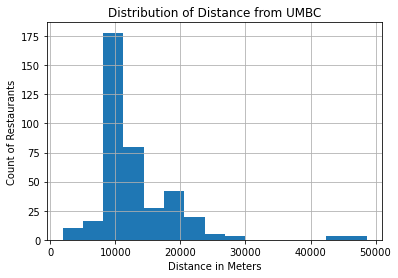

In [79]:
#we can look for trends in the data... how close are the bulk of the restaurants around UMBC?
hist = restaurants.hist(column="distance", bins=15) #histogram of the distance column to see the distribution

#set the labels
for ax in hist.flatten():
    ax.set_xlabel("Distance in Meters")
    ax.set_ylabel("Count of Restaurants")
    ax.set_title("Distribution of Distance from UMBC")

Based on the histogram above, we see that the data is skewed right, showing that the majority of restaurants are within 10,000 meters (~6 miles) of campus.  This takeaway is that this information can be of great influence for recruiting new students as there are a lot of options close to campus a short ride away.  My assumption here is that the cluster of these restaurants may be the proximity to Baltimore city where a lot of restuarants could be found.

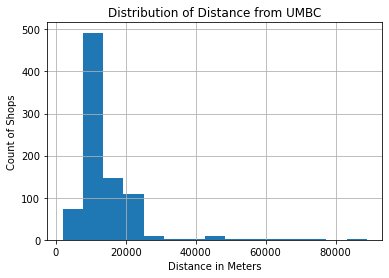

In [80]:
#we can look for trends in the data... how close are the bulk of the shops around UMBC?
hist = shops.hist(column="distance", bins=15)

for ax in hist.flatten():
    ax.set_xlabel("Distance in Meters")
    ax.set_ylabel("Count of Shops")
    ax.set_title("Distribution of Distance from UMBC")

We can do the same, but this time for shops - with many students living on campus or off campus but close to it, it is important to have convenient stores near by for the daily essentials.  Based on the histogram above, we see again that the majority of stores are also within the about 10,000 meters/6 miles away.  Another selling point to encourage students to come to UMBC for the convenience of what is around.

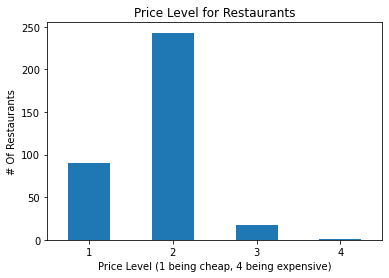

In [81]:
#we can look for trends in the data... what level of prices are the restaurants around UMBC?
restaurants["price"].value_counts().reindex([1,2,3,4]).plot(kind='bar', title="Price Level for Restaurants", ylabel="# Of Restaurants", xlabel="Price Level (1 being cheap, 4 being expensive)", rot=0);

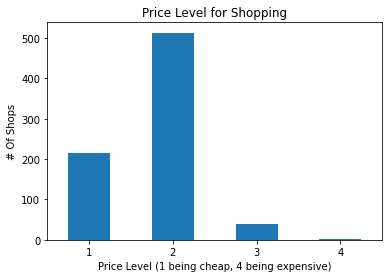

In [82]:
#we can look for trends in the data... what level of prices are the restaurants around UMBC?
shops["price"].value_counts().reindex([1,2,3,4]).plot(kind='bar', title="Price Level for Shopping", ylabel="# Of Shops", xlabel="Price Level (1 being cheap, 4 being expensive)", rot=0);

Another strong selling point of UMBC is the affordability.  College students tend to be in debt on loans and having local restaurants and shops that keep the essentials relatively cheap goes a long way for a students' financial well being.  Yelp defines these 4 price levels as: 1 - inexpensive, 2 - moderate, 3 - pricey, 4 - ultra high-end.  In the above 2 bar charts we see that the large majority of restaurants and shops around UMBC are either inexpensive or moderate.  Then there are also a few pricey and ultra high-end ones for the minority of students who can afford those luxuries.  This is perfect for recruiting new students to show the affordability of what is around, but also the diversity to have some pricey more fancy options as well.

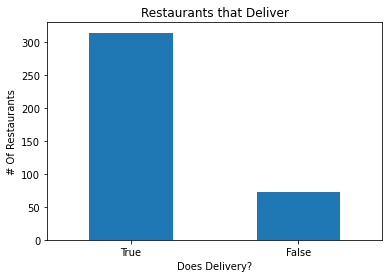

In [83]:
#The local businesses are more relevant for recruiting students that are going to live on campus.  For some, they
#may not have a car and it could be important to have businesses around that deliver
#Are there a lot of restaurants and shops that deliver?
restaurants["is_delivery"].value_counts().plot(kind='bar', title="Restaurants that Deliver", ylabel="# Of Restaurants", xlabel="Does Delivery?", rot=0);

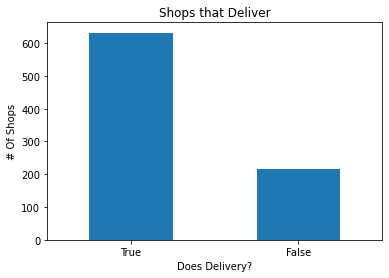

In [84]:
shops["is_delivery"].value_counts().plot(kind='bar', title="Shops that Deliver", ylabel="# Of Shops", xlabel="Does Delivery?", rot=0);

In the above two bar charts, we can see that the large majority of shops and restaurants around UMBC are available for delivery.  This is another potentially strong selling point to incoming students who may be living on campus without a car.  Over 300 restaurants deliver compared to under 100 that do not, and over 600 shops deliver compared to under 300 that do not.  The conclusion is that eating and shopping around UMBC is largely convenient and appealing for students who tend to have tight schedules but also want off-campus food or need shopping essentials.

In [74]:
#we could also put together a list of categories available within the 15 miles of UMBC for both restaurants
#and shops:
# here we make a function that takes in a df and returns a new df consisting of the categories and counts of each
#of those categories
def categoriesDF(dfToGetCategoriesFrom):
    categoriesFound = {}
    for index, row in dfToGetCategoriesFrom.iterrows():
        categories = row['categories'].split(', ')
        for category in categories:
            if category in categoriesFound:
                categoriesFound[category] += 1
            else:
                categoriesFound[category] = 1
    categoriesFound = {k: v for k, v in sorted(categoriesFound.items(), key=lambda item: item[1], reverse=True)}
    return pd.DataFrame(categoriesFound.items(), columns=["Category", "Number of Occurences"])

In [76]:
pd.set_option("display.max_rows", None, "display.max_columns", None) #set option to print entire dataframe
print(categoriesDF(shops))

                             Category  Number of Occurences
0              American (Traditional)                    85
1                  Breakfast & Brunch                    77
2                             Seafood                    67
3                          Sandwiches                    63
4                               Pizza                    55
5                        Coffee & Tea                    54
6                      American (New)                    54
7                             Italian                    49
8                                Bars                    49
9                          Sushi Bars                    41
10                            Mexican                    36
11                              Cafes                    36
12                           Bakeries                    36
13                             Indian                    35
14                      Mediterranean                    32
15                           Japanese   

In [77]:
#and for restaurants:
print(categoriesDF(restaurants))

                             Category  Number of Occurences
0                  Breakfast & Brunch                    43
1              American (Traditional)                    41
2                          Sandwiches                    31
3                             Seafood                    27
4                        Coffee & Tea                    27
5                      American (New)                    27
6                             Italian                    25
7                                Bars                    25
8                             Mexican                    24
9                       Mediterranean                    23
10                              Cafes                    22
11                         Sushi Bars                    22
12                              Pizza                    21
13                           Bakeries                    20
14                           Japanese                    18
15                             Indian   

Another potential selling point to students is the diversity of shops and restaurants around UMBC.  As shown above, there are 242 different categories of shops and 143 different categories for food.  One thing I noticed was that shops and restaurants seem to overlap in the categories that they have and what yelp uses to distinguish between a "shop" and a "restaurant" may be a fuzzy line to draw sometimes.  None the less, the diverse categories can still be seen as a selling point for UMBC if they advertise them correctly - showing the stats on the over 240 different kinds of shops and over 140 different kinds of places to eat and then listing a few of the popular ones and maybe a few of the unique ones too that might stand out or as something that may separate them from other schools.

# Conclusions

Some of the conclusions relevant to recruiting high quality students are:
 - An abundance of shops and restaurants are very close to campus within ~6 miles.  A short drive or uber ride away for students who do not have a car.
 - The shops and restaurants surrounding campus are very affordable.  Students coming to live on campus and pay the room and board fee will probably look to save in other areas and here we show the price level for most shops and restaurants is either inexpensive or moderate.
 - The large majority of shops and restaurants around campus deliver.  Living on campus without a car?  No problem at all just use the delivery services of these local shops and places to eat.
 - The options for shops and food around campus are so diverse - attracting prospective students from across the world.  With over 240 different categories of shops and over 140 different kinds of food to eat, there is something local around UMBC for just about everyone.
 
In conclusion, we have lots of stats and information that UMBC can advertise on flyers or their website to potential incoming students to encourage them/ give them reasons to attend UMBC.  I think the above findings are a good start to answering the question and when more time allows and after more research in what facts have the biggest impact on prospective students' decisions we can do even better at collecting information that will prove extremely helpful in recruiting the most talented students to UMBC.  The number of stats or information and ways to display that information are really endless and it will take time to find the optimal absolute best solution.